# Bayesian biodiversity: Experimental model pipeline

In [85]:
import polars as pl
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
import warnings
from polars.exceptions import PolarsInefficientMapWarning

warnings.filterwarnings("ignore", category=PolarsInefficientMapWarning)

In [3]:
# Load black for formatting
import jupyter_black

jupyter_black.load()

# Adjust display settings for polars
pl.Config(tbl_rows=100)
pl.Config(tbl_cols=50)

## Read and format data for model consumption

In [133]:
df_scaled = pl.read_parquet("../../data/output/model/model_data.parquet")
df_scaled.head()

shape: (5, 16)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┐
│ SS  ┆ SSB ┆ SSB ┆ Kin ┆ Max ┆ Pri ┆ You ┆ Int ┆ Mat ┆ Sec ┆ Pla ┆ Pas ┆ Cro ┆ Urb ┆ Roa ┆ Pop_de │
│ --- ┆ --- ┆ S   ┆ gdo ┆ _sc ┆ mar ┆ ng  ┆ erm ┆ ure ┆ ond ┆ nta ┆ tur ┆ pla ┆ an  ┆ d_d ┆ nsity_ │
│ str ┆ str ┆ --- ┆ m   ┆ ale ┆ y   ┆ sec ┆ edi ┆ sec ┆ ary ┆ tio ┆ e   ┆ nd  ┆ --- ┆ ens ┆ 10km   │
│     ┆     ┆ str ┆ --- ┆ d_a ┆ veg ┆ ond ┆ ate ┆ ond ┆ veg ┆ n   ┆ --- ┆ --- ┆ u8  ┆ ity ┆ ---    │
│     ┆     ┆     ┆ str ┆ bun ┆ eta ┆ ary ┆ sec ┆ ary ┆ eta ┆ for ┆ u8  ┆ u8  ┆     ┆ _10 ┆ f64    │
│     ┆     ┆     ┆     ┆ dan ┆ tio ┆ veg ┆ ond ┆ veg ┆ tio ┆ est ┆     ┆     ┆     ┆ km  ┆        │
│     ┆     ┆     ┆     ┆ ce  ┆ n   ┆ eta ┆ ary ┆ eta ┆ n   ┆ --- ┆     ┆     ┆     ┆ --- ┆        │
│     ┆     ┆     ┆     ┆ --- ┆ --- ┆ tio ┆ veg ┆ tio ┆ (in ┆ u8  ┆     ┆     ┆     ┆ f64 ┆        │
│     ┆     ┆     ┆     ┆ f64 ┆ u8  ┆ n   ┆ eta ┆ n   ┆ det ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ tio ┆ --- ┆ erm ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆     ┆     ┆     ┆     ┆     ┆ u8  ┆ …   ┆ u8  ┆ in… ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆     ┆ --- ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆ u8  ┆     ┆ u8  ┆     ┆     ┆     ┆     ┆     ┆        │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪════════╡
│ AD1 ┆ AD1 ┆ AD1 ┆ Ani ┆ 1.9 ┆ 0   ┆ 0   ┆ 1   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 11. ┆ 1.3051 │
│ _20 ┆ _20 ┆ _20 ┆ mal ┆ 274 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 389 ┆ 95     │
│ 02_ ┆ 02_ ┆ 02_ ┆ ia  ┆ 69  ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 075 ┆        │
│ _To ┆ _To ┆ _To ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ nha ┆ nha ┆ nha ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ sca ┆ sca ┆ sca ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ 1   ┆ 1   ┆ 1   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆     ┆ 2   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ AD1 ┆ AD1 ┆ AD1 ┆ Ani ┆ -0. ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 1   ┆ 0   ┆ 0   ┆ 0   ┆ 11. ┆ 7.0250 │
│ _20 ┆ _20 ┆ _20 ┆ mal ┆ 400 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 396 ┆ 52     │
│ 09_ ┆ 09_ ┆ 09_ ┆ ia  ┆ 622 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 655 ┆        │
│ _Ve ┆ _Ve ┆ _Ve ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ rga ┆ rga ┆ rga ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ ra  ┆ ra  ┆ ra  ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ 1   ┆ 1   ┆ 1   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆     ┆ 14  ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ AD1 ┆ AD1 ┆ AD1 ┆ Ani ┆ 1.6 ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 1   ┆ 0   ┆ 0   ┆ 0   ┆ 11. ┆ 5.2566 │
│ _20 ┆ _20 ┆ _20 ┆ mal ┆ 376 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 852 ┆ 33     │
│ 09_ ┆ 09_ ┆ 09_ ┆ ia  ┆ 09  ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 987 ┆        │
│ _Ve ┆ _Ve ┆ _Ve ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ rga ┆ rga ┆ rga ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ ra  ┆ ra  ┆ ra  ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ 1   ┆ 1   ┆ 1   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆     ┆ 9   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ AR1 ┆ AR1 ┆ AR1 ┆ Ani ┆ 6.9 ┆ 0   ┆ 0   ┆ 0 

In [109]:
group_vars = ["SS", "SSB", "SSBS", "Kingdom"]
response_var = ["Max_scaled_abundance"]
covariates = [
    "Primary vegetation",
    "Young secondary vegetation",
    "Intermediate secondary vegetation",
    "Mature secondary vegetation",
    "Secondary vegetation (indeterminate age)",
    "Plantation forest",
    "Pasture",
    "Cropland",
    "Urban",
    "Road_density_10km",
    "Pop_density_10km",
]

In [149]:
# Extract all unique groups and create a mapping dictionary
# Use the mapping dictionary to create an array with numerical group ids
groups = df_scaled.get_column(group_vars[-1]).unique().to_list()
group_code_map = {group: code for code, group in enumerate(groups)}
group_idx = (
    df_scaled.get_column(group_vars[-1])
    .map_elements(lambda x: group_code_map[x])
    .to_numpy()
)

# Do the same for the study ID and block ID
studies = df_scaled.get_column("SS").unique().to_list()
study_code_map = {study: code for code, study in enumerate(studies)}
study_idx = (
    df_scaled.get_column("SS").map_elements(lambda x: study_code_map[x]).to_numpy()
)

blocks = df_scaled.get_column("SSB").unique().to_list()
block_code_map = {block: code for code, block in enumerate(blocks)}
block_idx = (
    df_scaled.get_column("SSB").map_elements(lambda x: block_code_map[x]).to_numpy()
)

# Get a vector of output values
y = df_scaled.get_column(response_var[0]).to_numpy().flatten()

# Create the design matrix and add an intercept column
X = df_scaled.drop(group_vars + response_var).to_numpy()
X = np.hstack((np.ones((X.shape[0], 1)), X))

# Create coordinate dictionary
idx = np.arange(X.shape[0])
coords = {
    "idx": idx,
    "groups": groups,
    "covariates": ["Intercept"] + covariates,
    # "blocks": blocks,
    # "studies": studies,
}

# Convert numpy array to the precision actually needed, to increase sampling speed
y = y.astype(np.float32)
X = X.astype(np.float32)
group_idx = group_idx.astype(np.uint16)
study_idx = study_idx.astype(np.uint16)
block_idx = block_idx.astype(np.uint16)
idx = idx.astype(np.uint32)

## Model specification

**Likelihood** function for the abundance, $y_{ij}$:
$$
    y_{ij} \, | \, \mu_{ij} \sim \mathcal{N}(\mu_{ij}, \sigma_{ij}^2)
$$

**Expectation** of the abundance, $\mu_{ij}$:
$$
    \mu_{ij} = \beta_{j0} + \beta_{j1} x_{i1} + \dots + \beta_{jM} x_{iM} + \gamma_t x_t + \nu_b
$$
where $\beta_{jm}$ are parameters of the human pressure covariates, $\gamma_{tk}$ is the parameter for the control variable on study-level mean population, and $\nu_b$ is a block-level random effect.  

**Priors**:
$$
    \beta_{jm} \sim \mathcal{N}(\mu_{\beta_m}, \sigma_{\beta_m}^2) \hspace{0.2cm} \text{for} \; j = 1, \dots, J; \; m = 0, \dots, M
$$
$$
    \gamma_t \sim \mathcal{N}(\mu_{\gamma}, \sigma_{\gamma}^2) \hspace{0.2cm} \text{for} \; t = 1, \dots, T
$$
$$
    \nu_b \sim \mathcal{N}(\mu_{\nu}, \sigma_{\nu}^2) \hspace{0.2cm} \text{for} \; b = 1, \dots, B
$$
$$
    \sigma_{ij}^2 \sim \text{Half-Normal}(\phi_{\sigma_j}^2) \hspace{0.2cm} \text{for} \; i = 1, \dots, G \; 
    \text{in groups} \; j = 1, \dots, J
$$

**Hyperpriors:**
$$
    \mu_{\beta_m} \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2) \hspace{0.2cm} \text{for} \; m = 1, \dots, M
$$
$$
     \sigma_{\beta_m}^2 \sim \text{Half-Normal}(\phi_{\beta}^2) \hspace{0.2cm} \text{for} \; m = 1, \dots, M
$$
$$
    \phi_{\sigma_j}^2 \sim \text{Half-Normal}(\phi_{\sigma}^2) \hspace{0.2cm} \text{for} \; j = 1, \dots, J
$$

**Reparameterization:** To improve exploration of the posterior and achieve better convergence we let
$$
    \beta_{jm} = \mu_{\beta_m} + \mathcal{N}(0, 1) * \sigma_{\beta_m}^2 
$$

**Alternative distributions**:
- Likelihood: Student-T (more robust); Beta if not doing the logit transformation
- Variance: Half-Cauchy, Half-Student-T, Gamma / Inverse-Gamma

In [20]:
# Context manager for associating variables with a specific model
with pm.Model(coords=coords) as model:

    # Observed data that can be changed later on for train-test runs (hence MutableData)
    X_obs = pm.MutableData("X_obs", X, dims=("idx", "covariates"))
    y_obs = pm.MutableData("y_obs", y, dims="idx")

    # Hyperpriors
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=0.5, dims="covariates")
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=0.5, dims="covariates")

    # Priors
    beta_offset = pm.Normal("beta_offset", mu=0, sigma=1, dims=("groups", "covariates"))
    beta = pm.Deterministic("beta", mu_beta + beta_offset * sigma_beta)

    # Expected value and variance
    mu_obs = pm.Deterministic("mu_obs", pm.math.sum(X_obs * beta[group_idx], axis=1))
    phi_obs = pm.HalfNormal("phi_obs", sigma=0.5)

    # Likelihood function
    y_like = pm.Normal("y_like", mu=mu_obs, sigma=phi_obs, observed=y_obs, dims="idx")

In [ ]:
pm.model_to_graphviz(model)

## NUTS sampling

In [65]:
with model:
    trace = pm.sample(
        draws=10000,
        tune=10000,
        cores=4,
        chains=4,
        target_accept=0.99,
        nuts_sampler="numpyro",
    )

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

## Model evaluation

In [122]:
idata = az.convert_to_dataset(trace)
var_names = ["mu_beta", "sigma_beta", "beta"]

In [129]:
def summarize_sampling_statistics(trace, var_names):

    idata = az.convert_to_dataset(trace)

    # Divergences
    divergences = np.sum(trace.sample_stats["diverging"].values)
    print(f"There are {divergences} divergences in the sampling chains.")

    # Acceptance rate
    accept_rate = np.mean(trace.sample_stats["acceptance_rate"].values)
    print(f"The mean acceptance rate was {round(accept_rate, 3)}")

    # R-hat statistics
    r_hat = az.summary(idata, var_names=var_names, round_to=2)["r_hat"]
    mean_r_hat = round(np.mean(r_hat), 3)
    min_r_hat = round(np.min(r_hat), 3)
    max_r_hat = round(np.max(r_hat), 3)
    print(
        f"R-hat for {var_names} are: {mean_r_hat} (mean) | {min_r_hat} (min) | {max_r_hat} (max)"
    )

    # ESS statistics
    ess = az.summary(idata, var_names=var_names, round_to=2)["ess_bulk"]
    mean_ess = round(np.mean(ess), 0)
    min_ess = round(np.min(ess), 0)
    max_ess = round(np.max(ess), 0)
    print(
        f"ESS for {var_names} are: {int(mean_ess)} (mean) | {int(min_ess)} (min) | {int(max_ess)} (max)"
    )

In [130]:
summarize_sampling_statistics(trace, var_names=["mu_beta", "sigma_beta", "beta"])

There are 0 divergences in the sampling chains.
The mean acceptance rate was 0.989
R-hat for ['mu_beta', 'sigma_beta', 'beta'] are: 1.0 (mean) | 1.0 (min) | 1.0 (max)
ESS for ['mu_beta', 'sigma_beta', 'beta'] are: 19850.0 (mean) | 12446.0 (min) | 48159.0 (max)


In [154]:
with model:
    pm.set_data(
        {
            "X_obs": X,
            "y_obs": np.zeros(shape=y.shape),
        },
        coords={"idx": idx},
    )
    trace.extend(pm.sample_posterior_predictive(trace, predictions=False))

In [155]:
pp = trace.posterior_predictive["y_like"].mean(dim=["draw", "chain"]).values

In [156]:
r2_score(y, pp)

0.14082011392072635

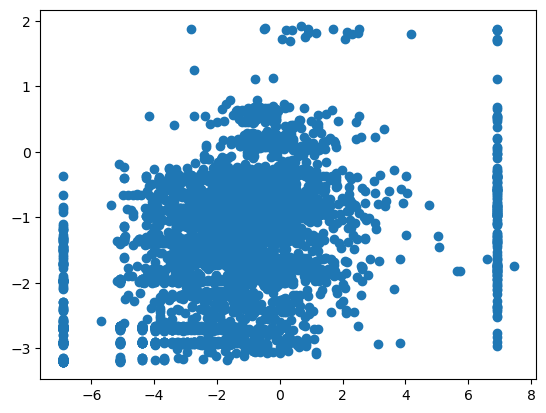

In [153]:
plt.scatter(y, pp)
plt.show()

In [146]:
import pymc as pm

idx = [0, 0, 0, 1, 1, 1]
coords = {
    "id": [0, 1],
    "obs_idx": list(range(len(idx))),
}
with pm.Model(coords=coords) as m:
    x = pm.MutableData("x", [0, 0, 0, 0, 0, 0], dims=("obs_idx",))
    mu_group = pm.Normal("mu_group")
    b = pm.Normal("b", mu_group, dims=("id",))
    mu = b[idx] * x
    obs = pm.Normal("obs", mu, observed=[0, 1, 2, 3, 4, 5], dims=("obs_idx",))

    idata = pm.sample()

In [ ]:
# Predict two new groups
idx = [0, 0, 1]
new_coords = {
    "id": [2, 3],
    "obs_idx": list(range(len(idx))),
}
with pm.Model(coords=new_coords) as pred_m:
    x = pm.Data("x", [0, 0, 0], dims=("obs_idx",))
    mu_group = pm.Normal("mu_group")
    # Needs a new name, so old b is not used!
    new_b = pm.Normal("new_b", mu_group, dims=("id",))
    mu = new_b[idx] * x
    obs = pm.Normal("obs", mu, dims=("obs_idx",))

    idata = pm.sample_posterior_predictive(idata, var_names=["obs"], predictions=True, extend_inferencedata=True)

## Prior predictive checks

In [23]:
def plot_prior_distribution(category, variable):

    if category == "prior":
        data = prior_samples.prior
    elif category == "prior_predictive":
        data = prior_samples.prior_predictive
    else:
        data = prior_samples.observed_data

    az.plot_dist(
        data[variable],
        figsize=(6, 3),
        kind="hist",
        color="C1",
        hist_kwargs=dict(alpha=0.6, bins=50),
    )

    plt.title(f"{category}: {variable}", fontsize=12)

    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)

    max_ticks = 15
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    plt.xticks(rotation=45)

    plt.show()

In [111]:
with model:
    prior_samples = pm.sample_prior_predictive(1000)

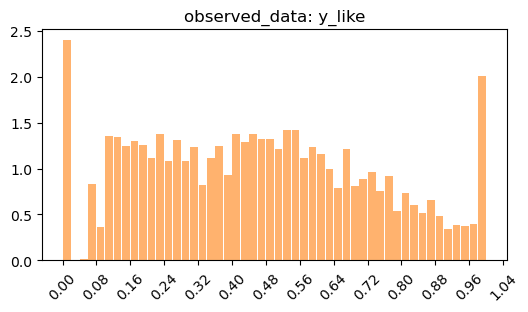

In [112]:
plot_prior_distribution("observed_data", "y_like")

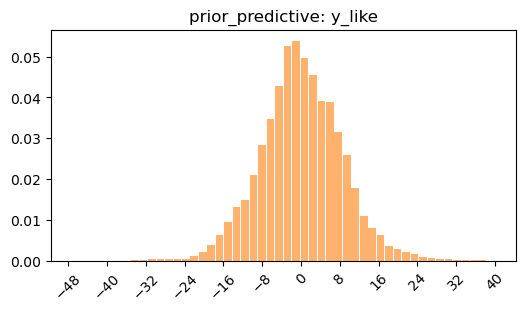

In [30]:
plot_prior_distribution("prior_predictive", "y_like")

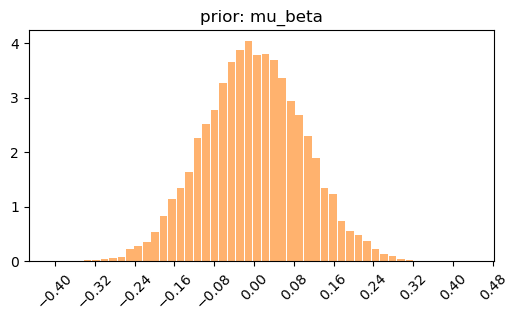

In [25]:
plot_prior_distribution("prior", "mu_beta")

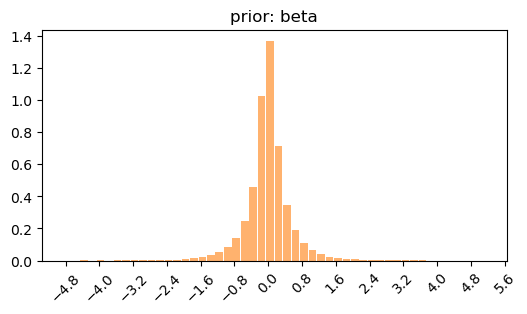

In [26]:
plot_prior_distribution("prior", "beta")

## Posterior predictive checks

In [396]:
# Convert trace to xarray for plotting
# Otherwise it will be converted over and over for each plot
idata = az.convert_to_dataset(trace)

### Generate trace plots

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (54), generating only 20 plots
  warnings.warn(


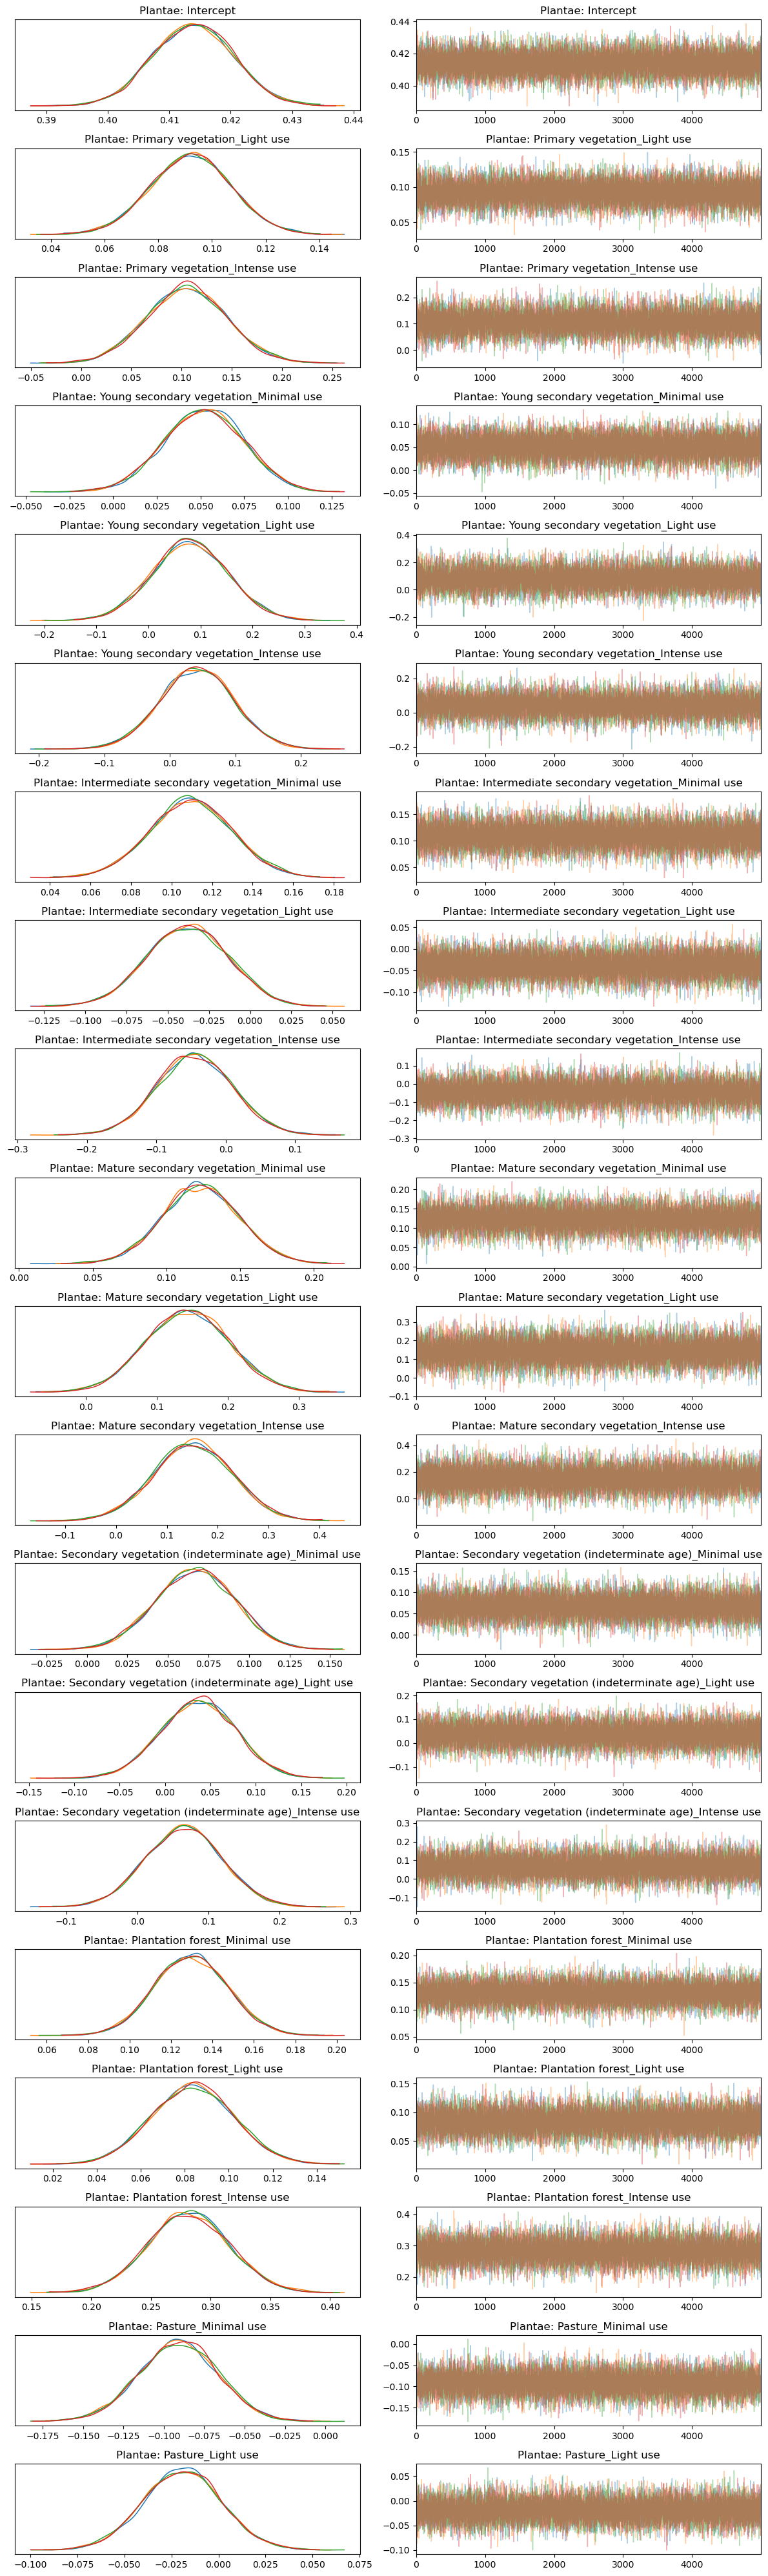

In [392]:
# Beta posteriors
trace_plot(trace=idata, var_names=["beta"])

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  warnings.warn(


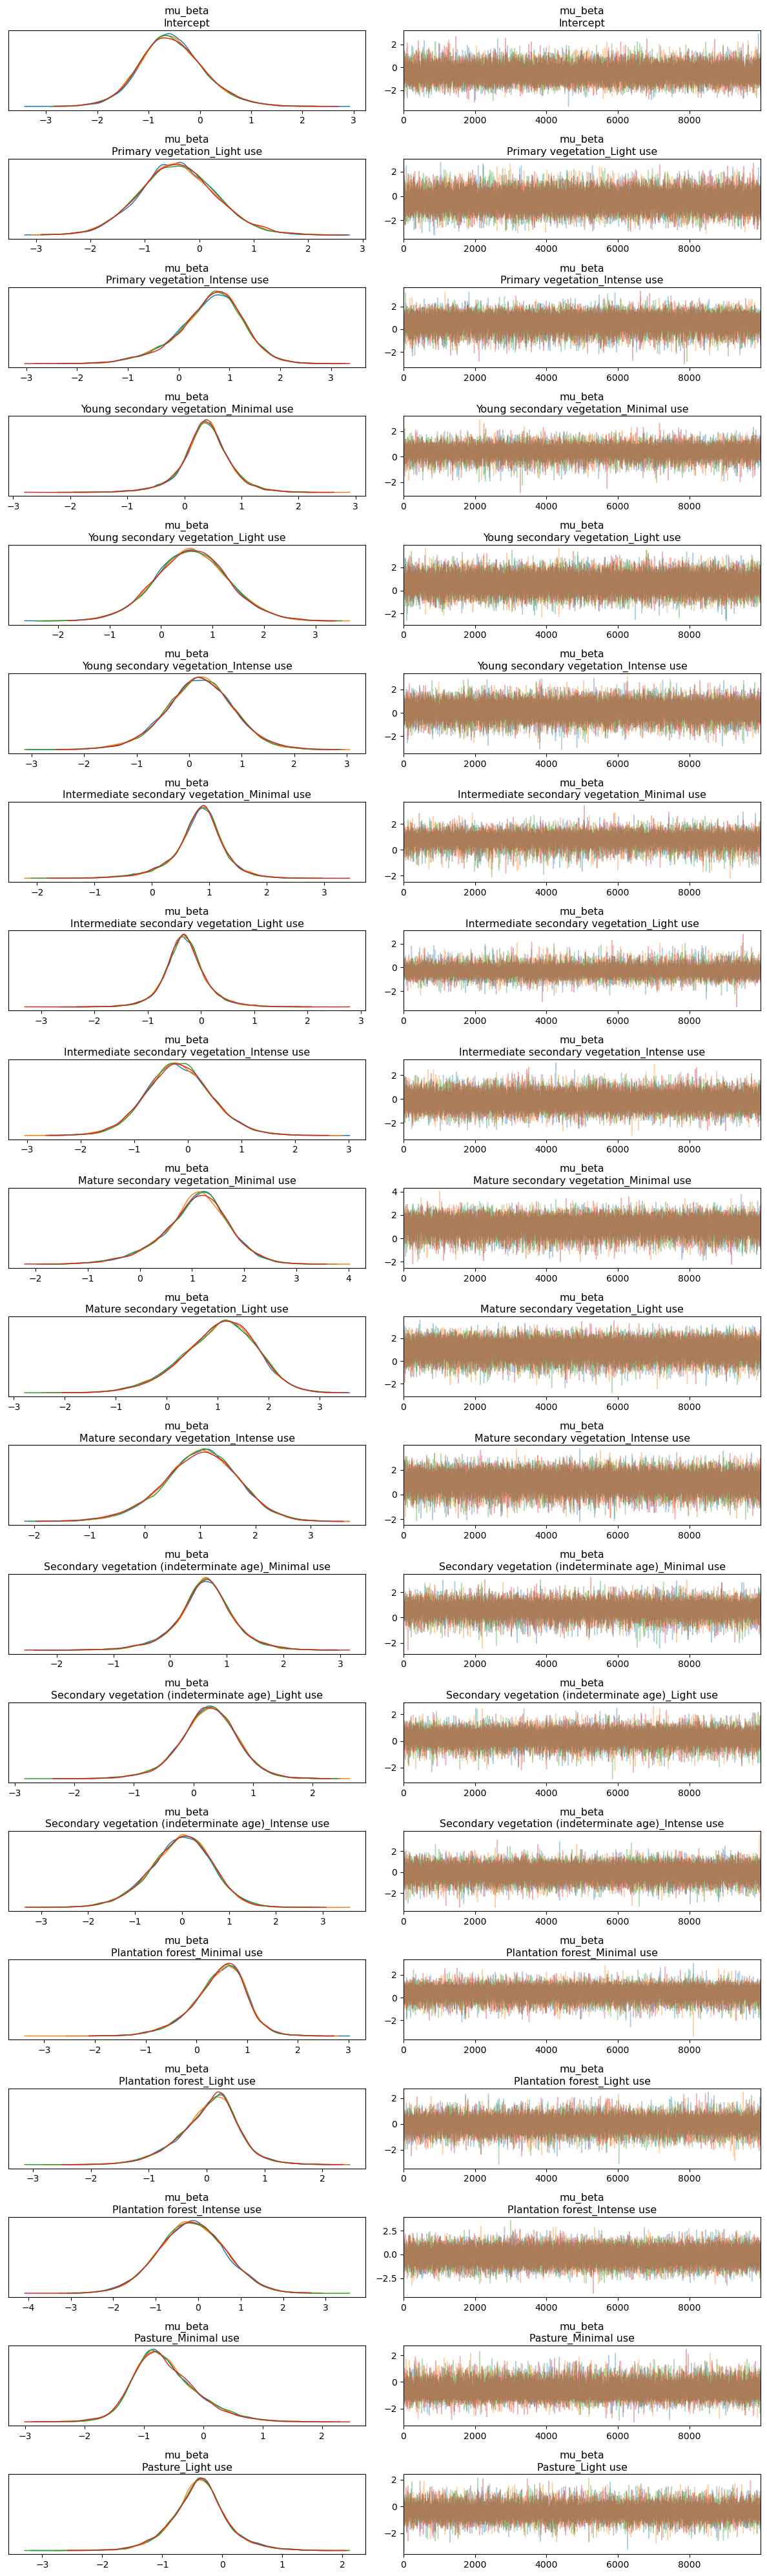

In [304]:
# Posteriors of hyperpriors: mu_beta
trace_plot(trace=idata, var_names=["mu_beta"])

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  warnings.warn(


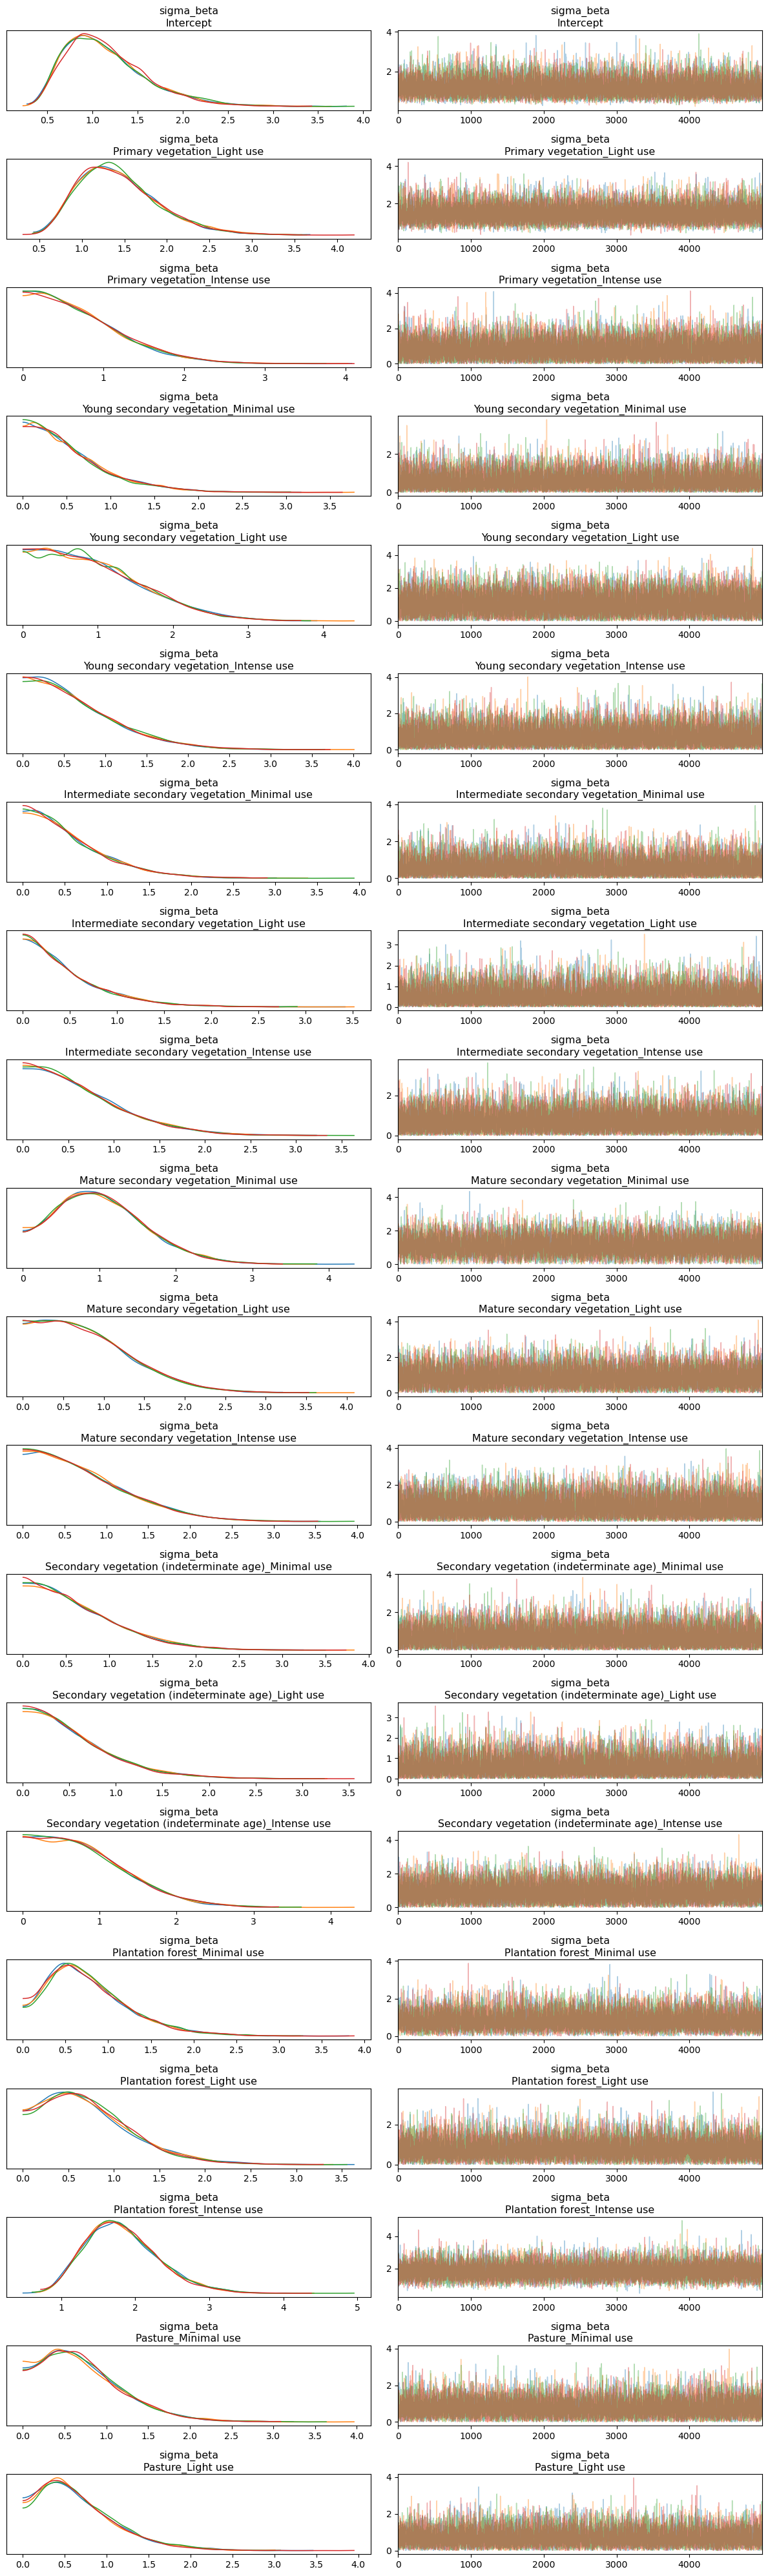

In [218]:
# Posteriors of hyperpriors: sigma_beta
trace_plot(trace=idata, var_names=["sigma_beta"])

### Check for divergences

In [398]:
posterior_samples.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()> Size: 8B
array(0)

### Check R-hat values

In [397]:
r_hat = az.summary(trace, var_names=["mu_beta", "sigma_beta", "beta"], round_to=2)[
    "r_hat"
]
filtered_r_hat = r_hat[(r_hat < 0.999) | (r_hat > 1.001)]
print(filtered_r_hat)

Series([], Name: r_hat, dtype: float64)


### ESS plot

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/essplot.py:205: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = data.dims["draw"]
/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/essplot.py:206: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_samples = n_draws * data.dims["chain"]
/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (54) in plot_ess, generating only 40 pl

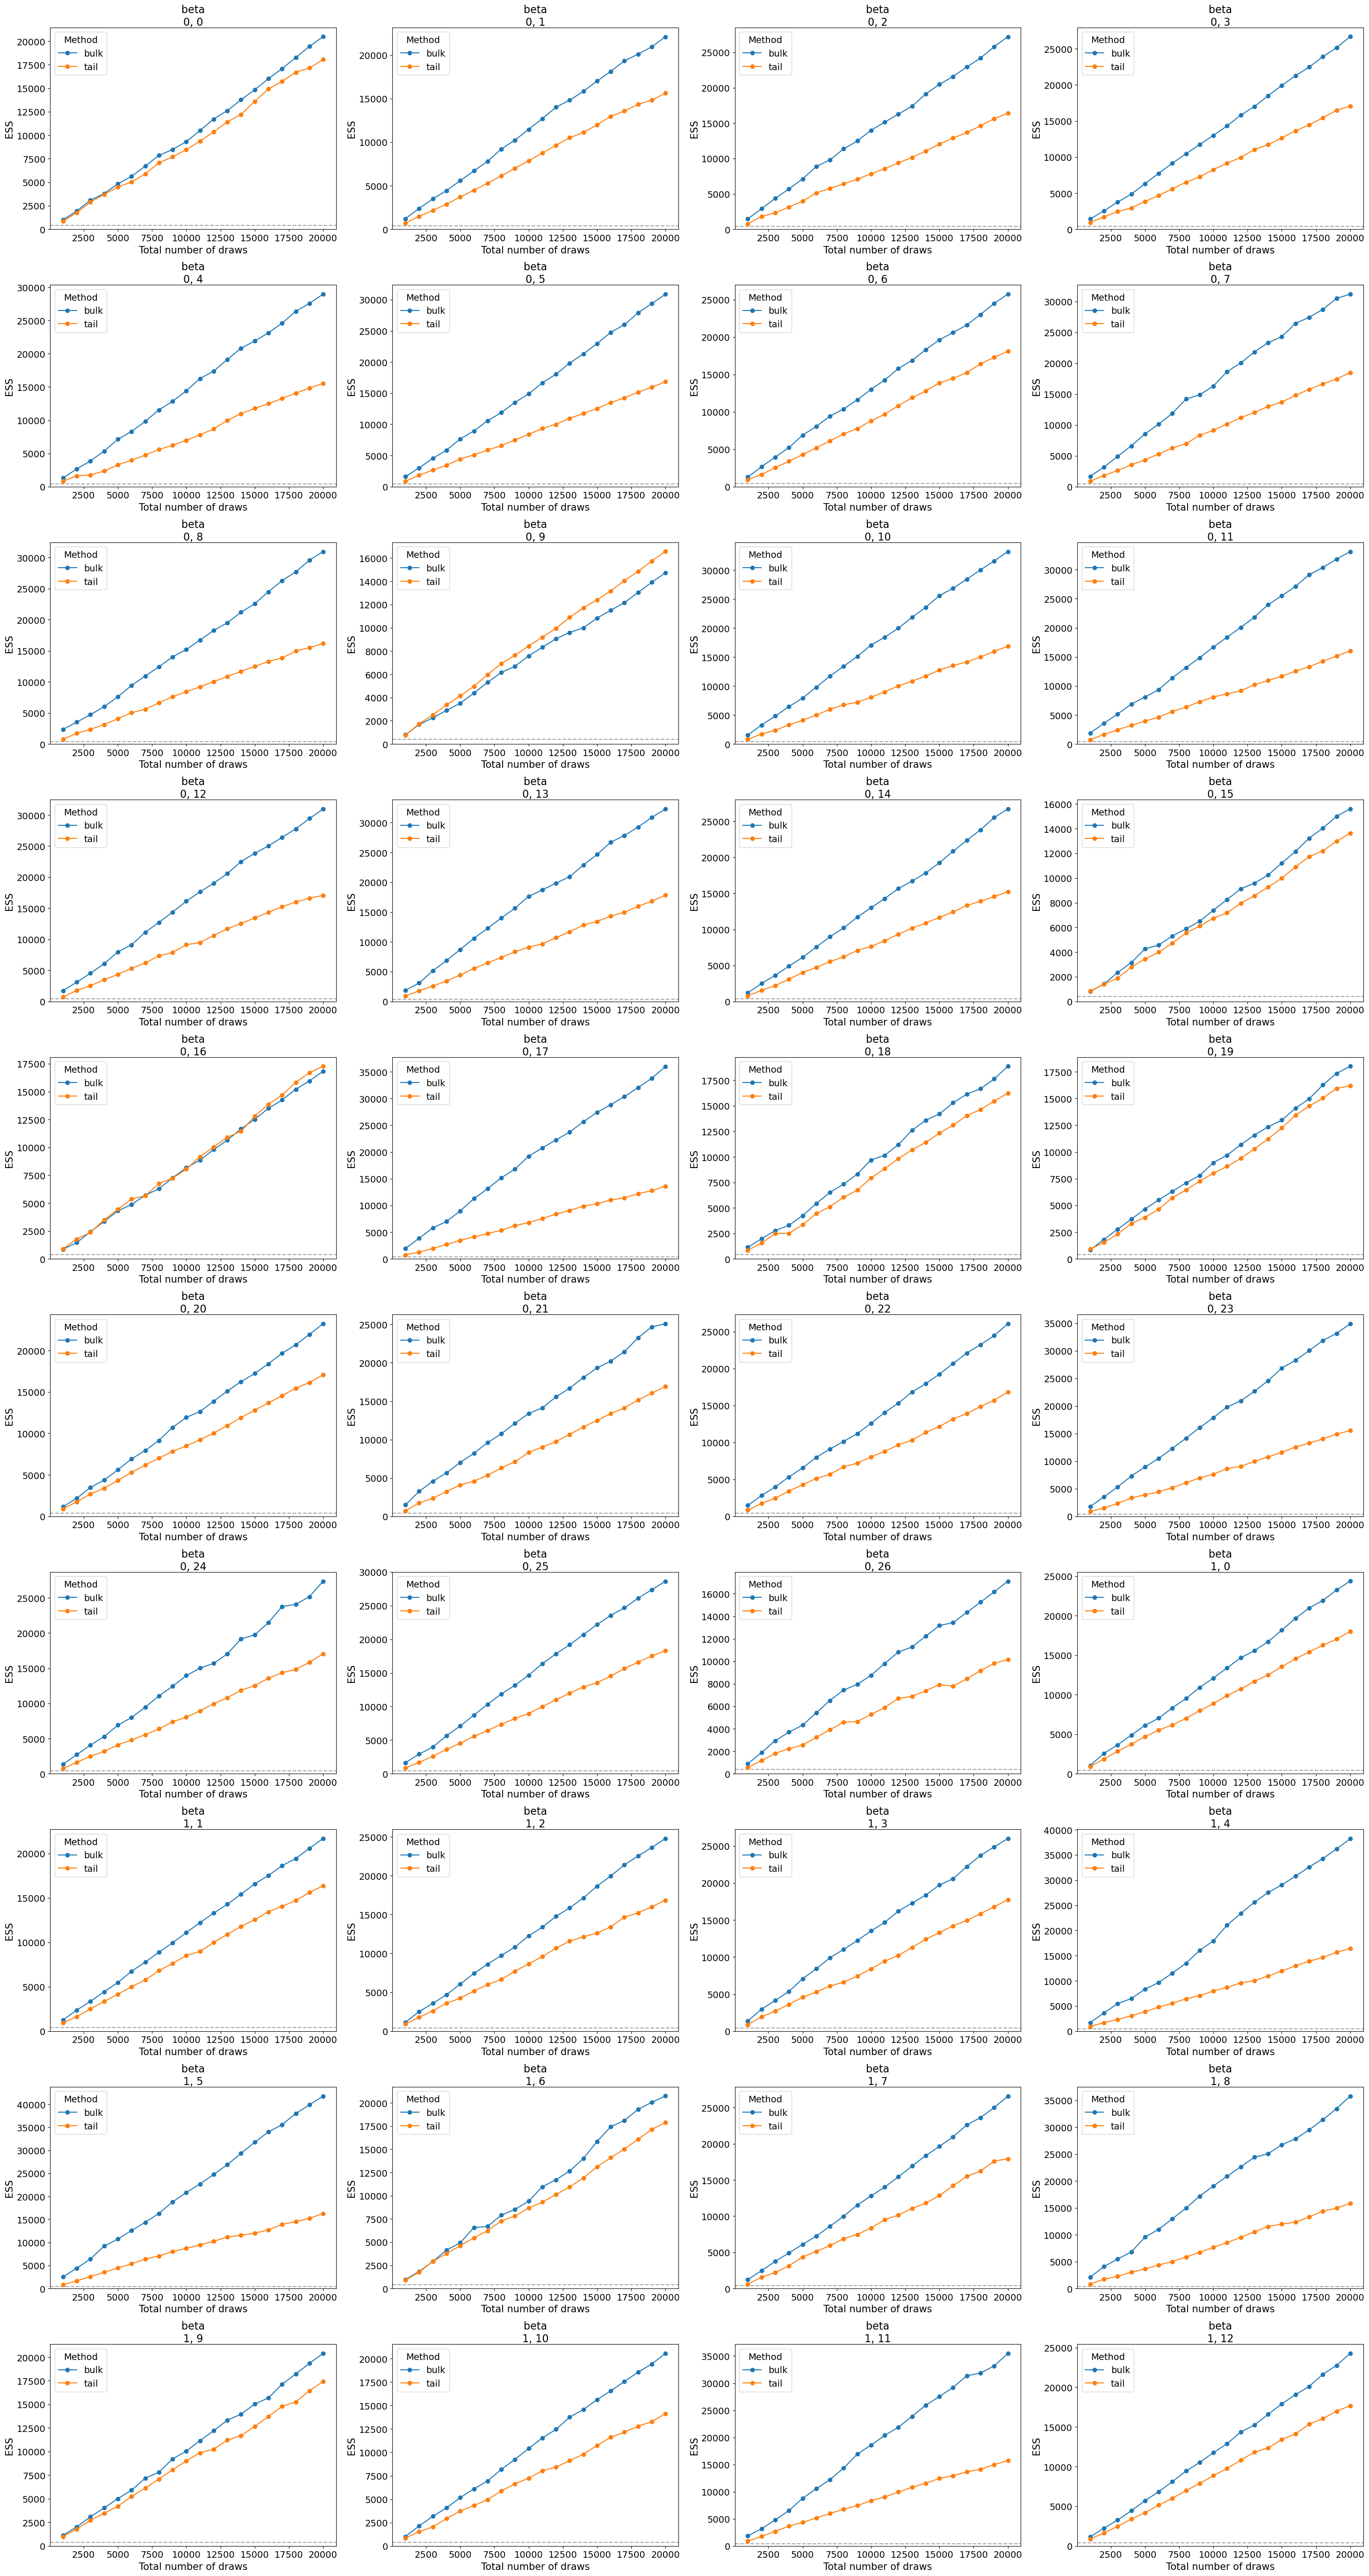

In [307]:
axes = az.plot_ess(trace, kind="evolution", var_names=["beta"])
# create_legible_trace_plot_titles(axes, group_mapping, variable_mapping)
plt.tight_layout()
plt.show()

### Energy plot

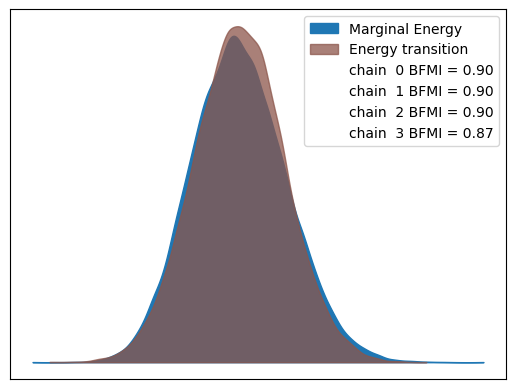

In [308]:
az.plot_energy(posterior_samples);

### Model summary

In [399]:
az.summary(posterior_samples, var_names=["mu_beta", "sigma_beta", "beta"], round_to=2)

mean    sd  hdi_3%  hdi_97%  \
mu_beta[Intercept]                              -0.54  0.64   -1.73     0.70   
mu_beta[Primary vegetation_Light use]           -0.39  0.72   -1.77     0.95   
mu_beta[Primary vegetation_Intense use]          0.62  0.66   -0.70     1.79   
mu_beta[Young secondary vegetation_Minimal use]  0.37  0.44   -0.49     1.25   
mu_beta[Young secondary vegetation_Light use]    0.60  0.73   -0.74     2.02   
...                                               ...   ...     ...      ...   
beta[1, 22]                                      0.04  0.23   -0.38     0.47   
beta[1, 23]                                     -0.64  0.74   -2.03     0.74   
beta[1, 24]                                     -0.26  0.31   -0.85     0.32   
beta[1, 25]                                     -0.40  0.04   -0.47    -0.33   
beta[1, 26]                                      0.56  0.04    0.48     0.65   

                                                 mcse_mean  mcse_sd  ess_bulk  \
mu_beta[Intercept]                                     0.0      0.0  31807.47   
mu_beta[Primary vegetation_Light use]                  0.0      0.0  34712.20   
mu_beta[Primary vegetation_Intense use]                0.0      0.0  34718.98   
mu_beta[Young secondary vegetation_Minimal use]        0.0      0.0  32964.73   
mu_beta[Young secondary vegetation_Light use]          0.0      0.0  48053.80   
...                                                    ...      ...       ...   
beta[1, 22]                                            0.0      0.0  42101.86   
beta[1, 23]                                            0.0      0.0  57079.50   
beta[1, 24]                                            0.0      0.0  43987.53   
beta[1, 25]                                            0.0      0.0  40220.07   
beta[1, 26]                                            0.0      0.0  40998.52   

                                                 ess_tail  r_hat  
mu_beta[Intercept]                               27552.39    1.0  
mu_beta[Primary vegetation_Light use]            28092.64    1.0  
mu_beta[Primary vegetation_Intense use]          28187.80    1.0  
mu_beta[Young secondary vegetation_Minimal use]  25630.55    1.0  
mu_beta[Young secondary vegetation_Light use]    31029.56    1.0  
...                                                   ...    ...  
beta[1, 22]                                      33377.23    1.0  
beta[1, 23]                                      33749.24    1.0  
beta[1, 24]                                      34694.92    1.0  
beta[1, 25]                                      32252.53    1.0  
beta[1, 26]                                      34514.73    1.0  

[108 rows x 9 columns]

### Forest plot of parameter values

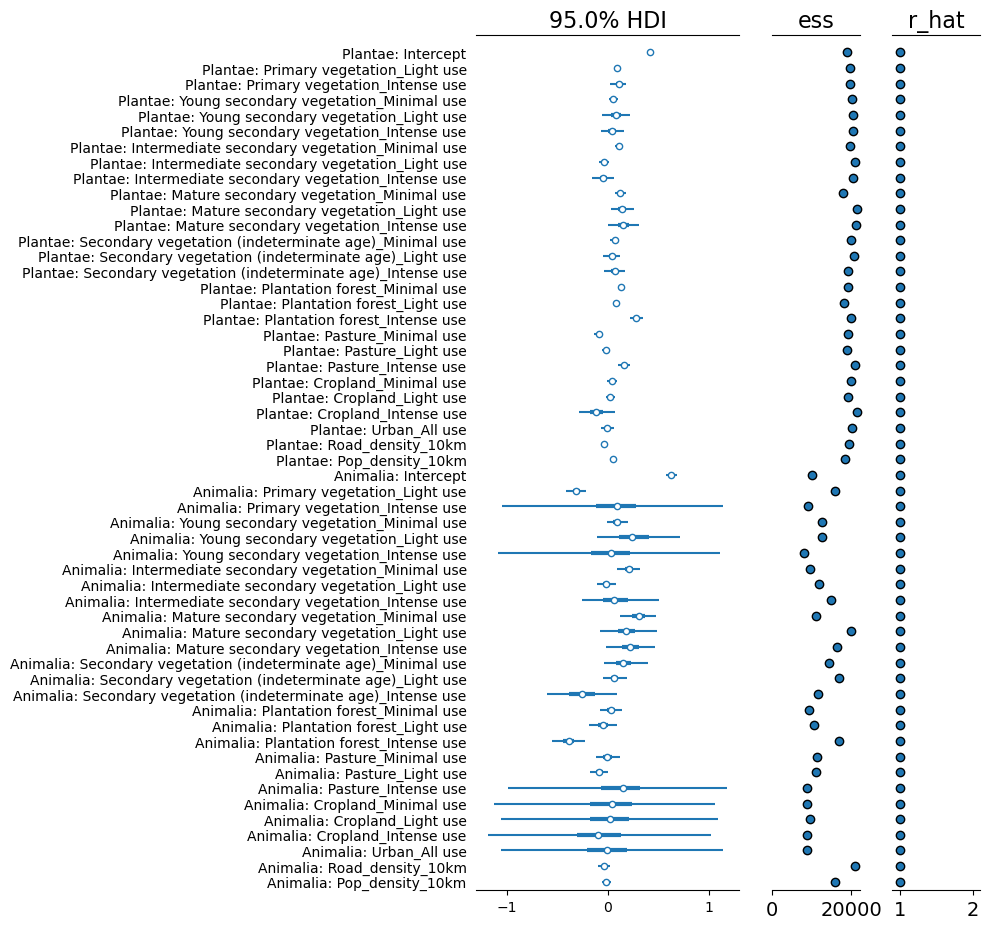

In [400]:
forest_plot(trace=idata, var_names=["beta"])

### Plot posterior distributions

In [ ]:
az.plot_posterior(posterior_samples, var_names=["beta"]);

### Sample from the posterior predictive distribution

In [401]:
with abundance_1:
    posterior_samples.extend(pm.sample_posterior_predictive(posterior_samples))

Sampling: [y_like]
INFO:pymc.sampling.forward:Sampling: [y_like]


/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())
/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(

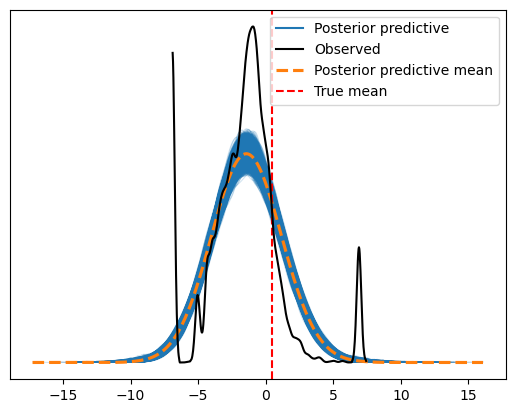

In [402]:
fig, ax = plt.subplots()
az.plot_ppc(posterior_samples, ax=ax)
ax.axvline(y.mean(), ls="--", color="r", label="True mean")
for label in ax.get_xticklabels():
    label.set_fontsize(10)
plt.xlabel("")
ax.legend(fontsize=10)
plt.show()

## Detailed debugging

### Autocorrelation in chains

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (216) in plot_autocorr, generating only 40 plots
  warnings.warn(


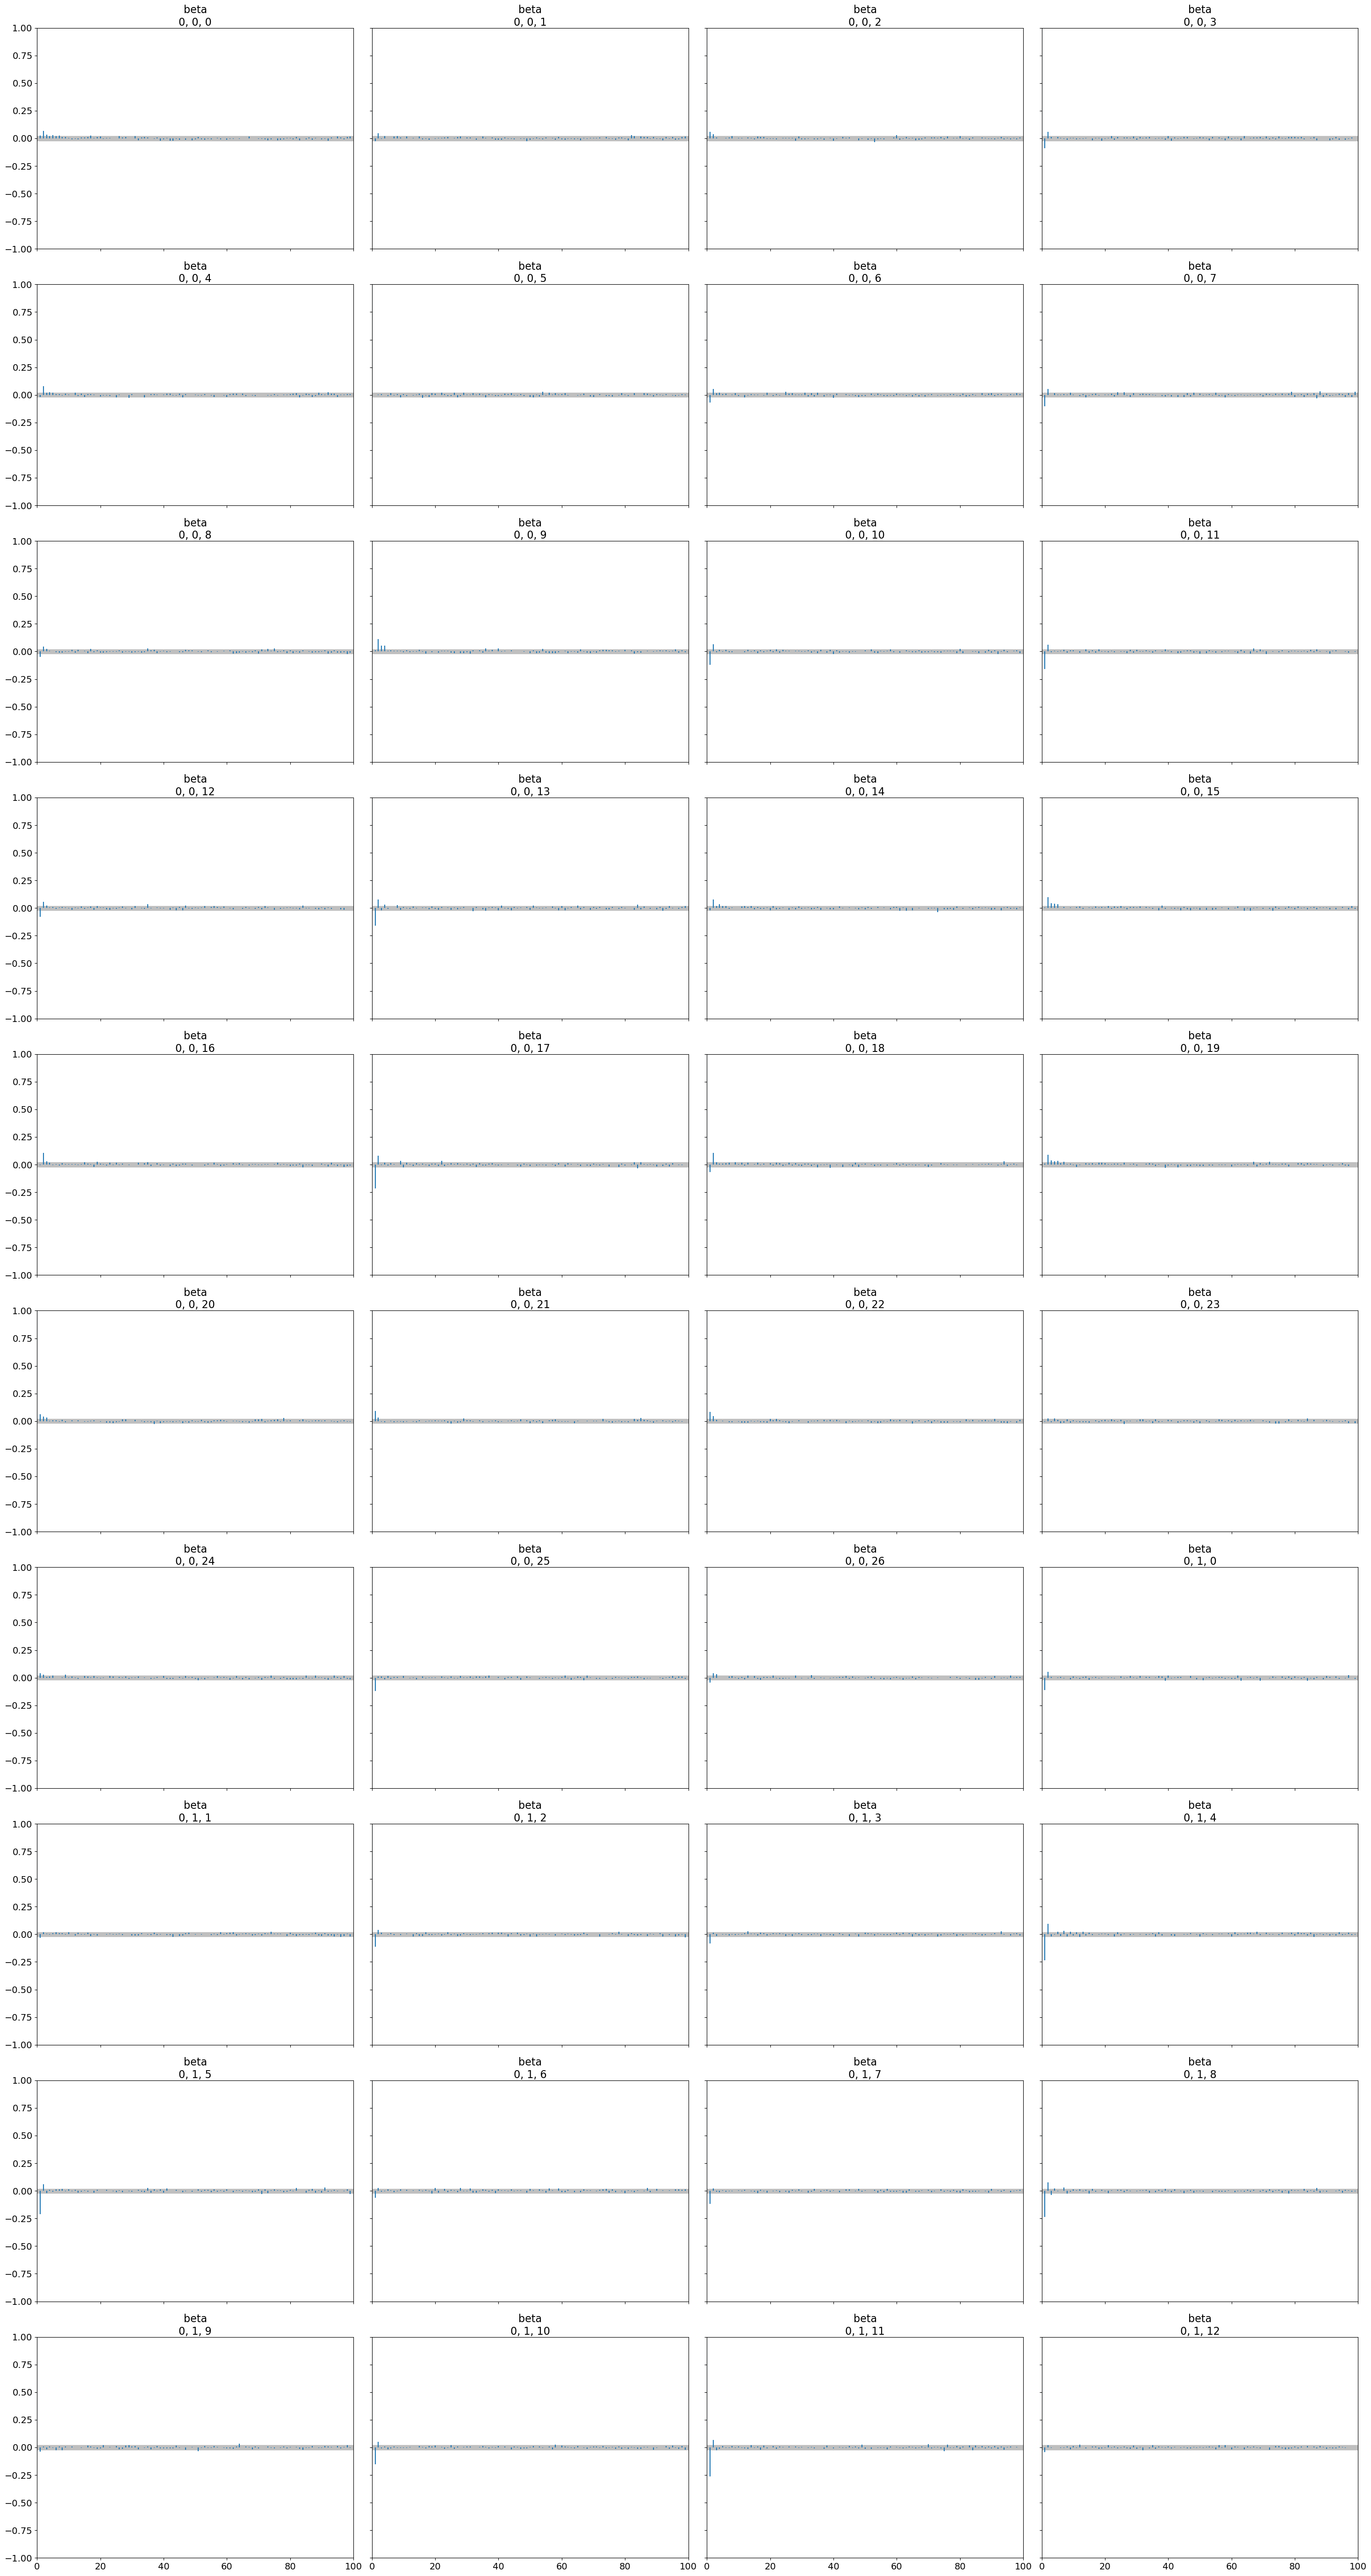

In [290]:
az.plot_autocorr(idata, var_names=["beta"])
plt.tight_layout()
plt.show()

In [271]:
df_scaled.select(covariates).corr()

shape: (26, 26)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ Pri ┆ Pri ┆ You ┆ You ┆ You ┆ Int ┆ Int ┆ Int ┆ Mat ┆ Mat ┆ Mat ┆ Sec ┆ Sec ┆ Sec ┆ Pla ┆ Pla ┆ Pla ┆ Pas ┆ Pas ┆ Pas ┆ Cro ┆ Cro ┆ Cro ┆ Urb ┆ Roa ┆ Pop │
│ mar ┆ mar ┆ ng  ┆ ng  ┆ ng  ┆ erm ┆ erm ┆ erm ┆ ure ┆ ure ┆ ure ┆ ond ┆ ond ┆ ond ┆ nta ┆ nta ┆ nta ┆ tur ┆ tur ┆ tur ┆ pla ┆ pla ┆ pla ┆ an_ ┆ d_d ┆ _de │
│ y   ┆ y   ┆ sec ┆ sec ┆ sec ┆ edi ┆ edi ┆ edi ┆ sec ┆ sec ┆ sec ┆ ary ┆ ary ┆ ary ┆ tio ┆ tio ┆ tio ┆ e_M ┆ e_L ┆ e_I ┆ nd_ ┆ nd_ ┆ nd_ ┆ All ┆ ens ┆ nsi │
│ veg ┆ veg ┆ ond ┆ ond ┆ ond ┆ ate ┆ ate ┆ ate ┆ ond ┆ ond ┆ ond ┆ veg ┆ veg ┆ veg ┆ n   ┆ n   ┆ n   ┆ ini ┆ igh ┆ nte ┆ Min ┆ Lig ┆ Int ┆ use ┆ ity ┆ ty_ │
│ eta ┆ eta ┆ ary ┆ ary ┆ ary ┆ sec ┆ sec ┆ sec ┆ ary ┆ ary ┆ ary ┆ eta ┆ eta ┆ eta ┆ for ┆ for ┆ for ┆ mal ┆ t   ┆ nse ┆ ima ┆ ht  ┆ ens ┆ --- ┆ _10 ┆ 10k │
│ tio ┆ tio ┆ veg ┆ veg ┆ veg ┆ ond ┆ ond ┆ ond ┆ veg ┆ veg ┆ veg ┆ tio ┆ tio ┆ tio ┆ est ┆ est ┆ est ┆ use ┆ use ┆ use ┆ l   ┆ use ┆ e   ┆ f64 ┆ km  ┆ m   │
│ n_L ┆ n_I ┆ eta ┆ eta ┆ eta ┆ ary ┆ ary ┆ ary ┆ eta ┆ eta ┆ eta ┆ n   ┆ n   ┆ n   ┆ _Mi ┆ _Li ┆ _In ┆ --- ┆ --- ┆ --- ┆ use ┆ --- ┆ use ┆     ┆ --- ┆ --- │
│ igh ┆ nte ┆ tio ┆ tio ┆ tio ┆ veg ┆ veg ┆ veg ┆ tio ┆ tio ┆ tio ┆ (in ┆ (in ┆ (in ┆ nim ┆ ght ┆ ten ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ --- ┆     ┆ f64 ┆ f64 │
│ t   ┆ nse ┆ n_M ┆ n_L ┆ n_I ┆ eta ┆ eta ┆ eta ┆ n_M ┆ n_L ┆ n_I ┆ det ┆ det ┆ det ┆ al  ┆ use ┆ se  ┆     ┆     ┆     ┆ f64 ┆     ┆ f64 ┆     ┆     ┆     │
│ use ┆ use ┆ ini ┆ igh ┆ nte ┆ tio ┆ tio ┆ tio ┆ ini ┆ igh ┆ nte ┆ erm ┆ erm ┆ erm ┆ use ┆ --- ┆ use ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│ --- ┆ --- ┆ m…  ┆ t…  ┆ n…  ┆ …   ┆ …   ┆ …   ┆ …   ┆ …   ┆ …   ┆ in… ┆ in… ┆ in… ┆ --- ┆ f64 ┆ --- ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│ f64 ┆ f64 ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ f64 ┆     ┆ f64 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆ f64 ┆ f64 ┆ f64 ┆ f64 ┆ f64 ┆ f64 ┆ f64 ┆ f64 ┆ f64 ┆ f64 ┆ f64 ┆ f64 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ 1.0 ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ 0.0 ┆ 0.0 │
│     ┆ 029 ┆ 059 ┆ 016 ┆ 020 ┆ 066 ┆ 056 ┆ 021 ┆ 049 ┆ 020 ┆ 016 ┆ 051 ┆ 033 ┆ 022 ┆ 079 ┆ 074 ┆ 038 ┆ 053 ┆ 067 ┆ 039 ┆ 049 ┆ 052 ┆ 012 ┆ 036 ┆ 612 ┆ 312 │
│     ┆ 499 ┆ 025 ┆ 312 ┆ 542 ┆ 66  ┆ 981 ┆ 601 ┆ 96  ┆ 542 ┆ 312 ┆ 113 ┆ 445 ┆ 612 ┆ 967 ┆ 469 ┆ 2   ┆ 353 ┆ 383 ┆ 377 ┆ 492 ┆ 019 ┆ 451 ┆ 989 ┆ 81  ┆ 23  │
│ -0. ┆ 1.0 ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ 0.0 ┆ 0.0 │
│ 029 ┆     ┆ 018 ┆ 005 ┆ 006 ┆ 020 ┆ 017 ┆ 006 ┆ 015 ┆ 006 ┆ 005 ┆ 015 ┆ 010 ┆ 007 ┆ 024 ┆ 023 ┆ 011 ┆ 016 ┆ 020 ┆ 012 ┆ 015 ┆ 016 ┆ 003 ┆ 011 ┆ 131 ┆ 170 │
│ 499 ┆     ┆ 296 ┆ 056 ┆ 368 ┆ 663 ┆ 663 ┆ 696 ┆ 487 ┆ 368 ┆ 056 ┆ 844 ┆ 367 ┆ 009 ┆ 788 ┆ 084 ┆ 841 ┆ 538 ┆ 887 ┆ 206 ┆ 341 ┆ 125 ┆ 86  ┆ 466 ┆ 25  ┆ 64  │
│ -0. ┆ -0. ┆ 1.0 ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ 0.0 │
│ 059 ┆ 018 ┆     ┆ 010 ┆ 012 ┆ 041 ┆ 035 ┆ 013 ┆ 030 ┆ 012 ┆ 010 ┆ 031 ┆ 020 ┆ 014 ┆ 049 ┆ 046 ┆ 023 ┆ 033 ┆ 041 ┆ 024 ┆ 030 ┆ 032 ┆ 007 ┆ 022 ┆ 009 ┆ 424 │
│ 025 ┆ 296 ┆     ┆ 117 ┆ 741 ┆ 344 ┆ 342 ┆ 398 ┆ 987 ┆ 741 ┆ 117 ┆ 702 ┆ 743 ┆ 024 ┆ 598 ┆ 188 ┆ 693 ┆ 091 ┆ 793 ┆ 423 ┆ 696 ┆ 264 ┆ 723 ┆ 941 ┆ 109 ┆ 24  │
│ -0. ┆ -0. ┆ -0. ┆ 1.0 ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ -0. ┆ 0.0 │
│ 016 ┆ 005 ┆ 010 ┆     ┆ 003 ┆ 01

## Custom plotting functions

In [302]:
# Mappings from indices to names
group_mapping = {code: group for code, group in enumerate(groups)}
variable_mapping = {code: var for code, var in enumerate(["Intercept"] + covariates)}

In [296]:
def trace_plot(trace, var_names):

    axes = az.plot_trace(
        data=trace,
        var_names=var_names,
        divergences="bottom",
        compact=False,  # Plot multidimensional variables in one plot
        combined=False,  # Combine chains into a single line
    )

    if var_names[0] == "beta":
        create_legible_trace_plot_titles(axes, group_mapping, variable_mapping)

    plt.tight_layout()
    plt.show()

In [297]:
def create_legible_trace_plot_titles(axes, group_mapping, variable_mapping):

    # Customizing the subplot titles
    for ax_row in axes:
        for ax in ax_row:
            original_title = ax.get_title()
            indices = original_title.split("\n")[1].split(", ")
            group_index = int(indices[0])
            variable_index = int(indices[1])

            # Mapping indices to names
            group_name = group_mapping[group_index]
            variable_name = variable_mapping[variable_index]

            # Setting the new title with both group name and variable name
            new_title = f"{group_name}: {variable_name}"
            ax.set_title(new_title)

In [299]:
def forest_plot(trace, var_names):

    axes = az.plot_forest(
        data=trace,
        var_names=var_names,
        combined=True,
        hdi_prob=0.95,
        r_hat=True,
        ess=True,
    )

    if var_names[0] == "beta":
        create_legible_forest_plot_labels(
            axes[0], var_names, group_mapping, variable_mapping
        )

    plt.tight_layout()
    plt.show()

In [300]:
def create_legible_forest_plot_labels(axes, var_names, group_mapping, variable_mapping):
    # Get the current y-tick labels
    labels = [item.get_text() for item in axes.get_yticklabels()]

    # Customizing the y-tick labels
    new_labels = []
    for label in labels:
        # Extract indices from the label
        indices = (
            label.replace("[", "")
            .replace("]", "")
            .replace(var_names[0], "")
            .split(", ")
        )
        group_index = int(indices[0])
        variable_index = int(indices[1])

        # Mapping indices to names
        group_name = group_mapping.get(group_index, f"Group_{group_index}")
        variable_name = variable_mapping.get(variable_index, f"Var_{variable_index}")

        # Construct the new label
        new_label = f"{group_name}: {variable_name}"
        new_labels.append(new_label)

    for label in axes.get_yticklabels():
        label.set_fontsize(10)
    for label in axes.get_xticklabels():
        label.set_fontsize(10)

    # Set the new labels to the y-axis
    axes.set_yticklabels(new_labels)

## Train, test and evaluation pipeline

### Evaluation metrics

In [ ]:
def symmetric_absolute_mean_percentage_error(
    y_true: np.array, y_pred: np.array, divisor: int = 1
) -> float:
    """
    Function to calculate prediction accuracy, defined as 1 - symmetric mean
    absolute percentage error. (sMAPE). Can either use the "classic" version
    that produces outputs on a scale 0-200% (by using 2 as the divisor) or a
    version on the scale 0-100% (by using 1 instead). More details:
    https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

    Args:
        y_true (np.array): The observed values.
        y_pred (np.array): The corresponding model predictions.
        divisor (int): Number to divide the sum of the prediction and actual
            value with. Defaults to 1.

    Returns:
        The sMAPE value for these two arrays.
    """
    # Check that the divisor argument is valid
    assert divisor in [1, 2], "Divisor argument must be 1 or 2"

    # Perform the accuracy calculation of 1 - sMAPE
    smape = 100 * (
        1
        - np.mean(
            np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) / divisor)
        )
    )
    return smape

In [ ]:
def calculate_bic(log_likelihood: float, nb_obs: int, nb_params: int) -> float:
    """
    Calculates the Bayesian information criterion.

    Args:
        log_likelihood: Log likelihood of data under this model.
        nb_obs: Number of observations in training data.
        nb_params: Number of parameters in model (incl. intercept).

    Returns:
        Calculated BIC score.
    """
    return -2.0 * log_likelihood + np.log(nb_obs) * nb_params

In [ ]:
def calculate_aic(log_likelihood: float, nb_obs: int, nb_params: int) -> float:
    """
    Calculates the Akaike information criterion.

    Args:
        log_likelihood: Log likelihood of data under this model.
        nb_obs: Number of observations in training data.
        nb_params: Number of parameters in model (incl. intercept).

    Returns:
        Calculated AIC score.
    """
    return -2.0 * log_likelihood + 2.0 * nb_params

### Evaluation, train and test splits

In [ ]:
def create_stratification_column(
    df: pl.DataFrame, stratify_groups: List[str]
) -> pl.DataFrame:

    # Ensure that all group columns are in string format
    for group in stratify_groups:
        df = df.with_columns(pl.col(group).cast(pl.String))

    # If there are multiple groups passed as input, concatenate the string
    # values of the group columns into a single string
    if len(stratify_groups) > 1:
        df = df.with_columns(
            pl.concat_str(groups, separator="_").alias("Stratify_group")
        )
    else:
        df = df.rename(mapping={group: "Stratify_group"})

    # Encode the stratify groups numerically
    # le = LabelEncoder()
    # df = df.to_pandas()  # Need pandas dataframe for this step
    # df["stratify_code"] = le.fit_transform(df["Stratify_group"])
    # df = pl.from_pandas(df)

    return df

In [ ]:
df_strat = create_stratification_column(df_dummies, stratify_groups=["Order"])

In [390]:
def stratified_validate_train_test_split(
    df: pl.DataFrame,
    y_var: str,
    X_vars: List[str],
    re_groups: List[str],
    test_size: float = 0.2,
) -> Tuple[pl.DataFrame, pl.DataFrame]:

    # Make a copy of the dataframe, and convert to pandas
    df = df.clone().to_pandas()

    # Perform the split with stratification based on the stratify_groups
    X_train_test, X_validate, y_train_test, y_validate = train_test_split(
        df[X_vars + re_groups + ["Stratify_group"]],
        df[y_var],
        test_size=test_size,
        stratify=df["Stratify_group"],
    )

    # Concatenate into two dataframes, one for train-test and one for validation
    df_train_test = pl.from_pandas(pd.concat(
        [y_train_test, X_train_test], axis="columns", ignore_index=True
    ))
    df_validate = pl.from_pandas(pd.concat([y_validate, X_validate])), axis="columns", ignore_index=True)

    return df_train_test, df_validate

SyntaxError: unmatched ')' (1791721871.py, line 24)

In [ ]:
df_train_test, df_validate = stratified_validate_train_test_split(
    df_strat,
    y_var="Scaled_abundance",
    X_vars=["Pop_density_1km", "Road_density_50km"],
    re_groups=["SSB"],
    test_size=0.2,
)

In [ ]:
df_train_test

In [ ]:
def stratified_kfold_split(
    df: pl.DataFrame,
    y_var: str,
    X_vars: List[str],
    k: int = 5,
) -> Tuple[List[pl.DataFrame], List[pl.DataFrame], List[pl.Series], List[pl.Series]]:

    # Make a copy of the dataframe
    df = df.clone()

    # Lists for storing the train and test datasets
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

    # Set up stratified k-fold sampler object and sample using the
    # stratify code (as the "y class label") for stratification
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, test_index in skf.split(X=df, y=df["Stratify_group"]):
        X_train, X_test = df[train_index, X_vars], df[test_index, X_vars]
        y_train, y_test = df[train_index, y_var], df[test_index, y_var]

        # Store the data for this fold
        X_train_list.append(X_train)
        X_test_list.append(X_test)
        y_train_list.append(y_train)
        y_test_list.append(y_test)

    return X_train_list, X_test_list, y_train_list, y_test_list

In [ ]:
X_train_list, X_test_list, y_train_list, y_test_list = stratified_kfold(
    df_train_test,
    y_var="Scaled_abundance",
    X_vars=["Pop_density_1km", "Road_density_50km"],
    k=5,
)

In [ ]:
model_dict = {
    "model": abundance_1,
    "
}

In [ ]:
def run_cross_validation(X_train_list, X_test_list, y_train_list, y_test_list):

    

## Variational inference

In [ ]:
with abundance_1:
    vi_posterior = pm.fit()

In [ ]:
vi_samples = vi_posterior.sample(10000)

In [ ]:
az.plot_forest(vi_samples, var_names=["beta"], combined=True, hdi_prob=0.95);

In [ ]:
az.plot_posterior(vi_samples, var_names=["beta", "alpha"]);

## Archive: Stuff that "worked"

In [ ]:
# Context manager for associating variables with a specific model
with pm.Model(coords=coords) as abundance_1:

    # Observed data that be changed later on for train-test runs (hence MutableData)
    X_obs = pm.MutableData("X_obs", X, dims=("idx", "covariates"))
    y_obs = pm.MutableData("y_obs", y, dims="idx")

    # Hyperpriors
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=1, dims="covariates")
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=1, dims="covariates")
    # phi = pm.HalfNormal("phi", sigma=0.5, dims="groups")

    # Priors
    beta_offset = pm.Normal("beta_offset", mu=0, sigma=1, dims=("groups", "covariates"))
    beta = pm.Deterministic("beta", mu_beta + beta_offset * sigma_beta)
    # gamma = pm.Normal("gamma", mu=0, sigma=1, dims="studies")
    nu = pm.Normal("nu", mu=0, sigma=1, dims="blocks")

    # Expected value and variance
    # mu_obs = pm.Deterministic(
    # "mu_obs",
    # pm.math.sum(X_obs * beta[group_idx], axis=1) + gamma[study_idx] + nu[block_idx],
    # )
    mu_obs = pm.Deterministic("mu_obs", pm.math.sum(X_obs * beta[group_idx], axis=1))
    # phi_obs = pm.HalfNormal("phi_obs", sigma=phi[group_idx], dims="idx")
    phi_obs = pm.HalfNormal("phi_obs", sigma=1)

    # LIKELIHOOD FUNCTION
    y_like = pm.Normal("y_like", mu=mu_obs, sigma=phi_obs, observed=y_obs, dims="idx")

In [ ]:
with abundance_1:
    posterior_samples = pm.sample(
        draws=1000,
        tune=1000,
        cores=4,
        chains=4,
        target_accept=0.95,
        nuts_sampler="numpyro",
    )